# Evaluation and Metrics

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import PrecisionRecallDisplay
from requests import get

In [41]:
URL = 'http://localhost:8983/solr/movies/select'

In [42]:
# METRICS TABLE
# Define custom decorator to automatically calculate metric based on key
metrics = {}
metric = lambda f: metrics.setdefault(f.__name__, f)

@metric
def ap(results, relevant):
    """Average Precision"""
    relevant_index = []
    index = 0
    for res in results:
        if (index != 0 and res['imdb_title_id'] in relevant) or (index == 0 and res['imdb_title_id'][0] in relevant):
            relevant_index.append(index)
        index = index + 1

    if len(relevant_index) == 0:
        return 0

    precision_values = [
        len([
            doc
            for doc in results[:idx]
            if (index != 0 and doc['imdb_title_id'] in relevant) or (index == 0 and doc['imdb_title_id'][0] in relevant)
        ]) / idx
        for idx in range(1, len(results) + 1)
    ]

    precision_sum = 0
    for ind in relevant_index:
        precision_sum = precision_sum + precision_values[ind]

    return precision_sum / len(relevant_index)

@metric
def p10(results, relevant, n=10):
    """Precision at N"""
    return len([doc for doc in results[:n] if doc['imdb_title_id'] in relevant])/n

def calculate_metric(key, results, relevant):
    return metrics[key](results, relevant)

# Define metrics to be calculated
evaluation_metrics = {
    'ap': 'Average Precision',
    'p10': 'Precision at 10 (P@10)'
}

def metrics_export_table(results: list, relevant: list):
    df = pd.DataFrame([['Metric','Value']] +
        [
            [evaluation_metrics[m], calculate_metric(m, results, relevant)]
            for m in evaluation_metrics
        ]
    )

    return df

In [43]:
# PRECISION-RECALL CURVE
# Calculate precision and recall values as we move down the ranked list
def curve(results: list, relevant: list):
    precision_values = [
        len([
            doc 
            for doc in results[:idx]
            if doc['imdb_title_id'] in relevant
        ]) / idx 
        for idx, _ in enumerate(results, start=1)
    ]

    recall_values = [
        len([
            doc for doc in results[:idx]
            if doc['imdb_title_id'] in relevant
        ]) / len(relevant)
        for idx, _ in enumerate(results, start=1)
    ]

    precision_recall_match = {k: v for k,v in zip(recall_values, precision_values)}

    # Extend recall_values to include traditional steps for a better curve (0.1, 0.2 ...)
    recall_values.extend([step for step in np.arange(0, 1.1, 0.3) if step not in recall_values])
    recall_values = sorted(set(recall_values))

    # Extend matching dict to include these new intermediate steps
    for idx, step in enumerate(recall_values):
        if idx > 0 and step not in precision_recall_match:
            if recall_values[idx-1] in precision_recall_match:
                precision_recall_match[step] = precision_recall_match[recall_values[idx-1]]
            else:
                precision_recall_match[step] = precision_recall_match[recall_values[idx+1]]

    return PrecisionRecallDisplay([precision_recall_match.get(r) for r in recall_values], recall_values)

In [44]:
def get_results(params: dict):
    return get(URL, params=params).json()['response']['docs']

In [45]:
def print_titles(dataset: list):
    for title in dataset:
        print('%s: %d %s' % (title['imdb_title_id'], title['year'], title['original_title']))

## Experiment 1 - Matrix Trilogy

In [46]:
# schema-less
relevant = list(map(lambda el: el.strip(), open('matrix_qrels.txt').readlines()))

standard_params = {
    'q': 'title:matrix original_title:matrix description:(matrix neo) plot:(matrix neo) ',
    'wt': 'json',
    'defType': 'edismax'
}

schemaless_results = get_results(params=standard_params)

In [47]:
standard_results = get_results(params=standard_params)

enhanced_params = {
    'q': '(original_title:matrix title:matrix) AND (description:neo plot:neo)',
    'wt': 'json',
    'qf': 'original_title description^2 plot^3',
    'defType': 'edismax'
}

enhanced_results = get_results(params=enhanced_params)

In [48]:
print_titles(standard_results)

tt0234215: 2003 The Matrix Reloaded
tt0242653: 2003 The Matrix Revolutions
tt0133093: 1999 The Matrix
tt0970173: 2007 Buhera mátrix
tt0415955: 2004 Maarek hob
tt0292097: 2000 Markova: Comfort Gay
tt0074883: 1976 Maîtresse
tt0102421: 1991 Mayrig
tt0437526: 2007 Une vieille maîtresse
tt0084315: 1982 Les maîtres du temps


In [49]:
print_titles(enhanced_results)

tt0234215: 2003 The Matrix Reloaded
tt0242653: 2003 The Matrix Revolutions
tt0133093: 1999 The Matrix


In [50]:
schemaless_table = metrics_export_table(results=schemaless_results, relevant=relevant)
standard_table = metrics_export_table(results=standard_results, relevant=relevant)
enhanced_table = metrics_export_table(results=enhanced_results, relevant=relevant)

schemaless_curve = curve(results=schemaless_results, relevant=relevant)
standard_curve = curve(results=standard_results, relevant=relevant)
enhanced_curve = curve(results=enhanced_results, relevant=relevant)

In [51]:
print(schemaless_table)
print(standard_table)
print(enhanced_table)

                        0      1
0                  Metric  Value
1       Average Precision    1.0
2  Precision at 10 (P@10)    0.3
                        0      1
0                  Metric  Value
1       Average Precision    1.0
2  Precision at 10 (P@10)    0.3
                        0      1
0                  Metric  Value
1       Average Precision    1.0
2  Precision at 10 (P@10)    0.3


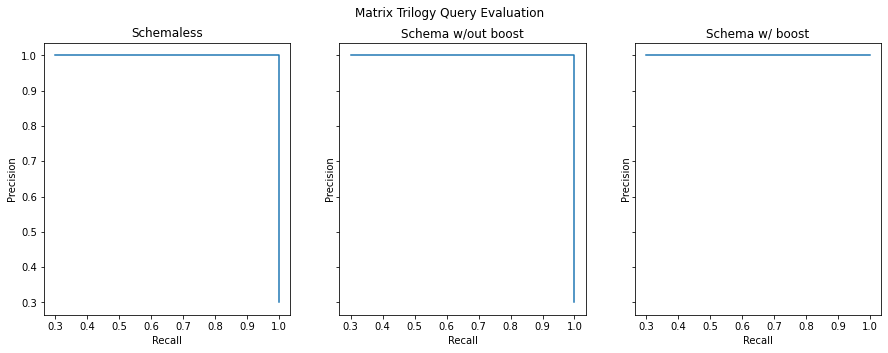

In [52]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(15,5))

ax1.set_title('Schemaless')
ax2.set_title('Schema w/out boost')
ax3.set_title('Schema w/ boost')
fig.suptitle('Matrix Trilogy Query Evaluation')

schemaless_curve.plot(ax=ax1)
standard_curve.plot(ax=ax2)
enhanced_curve.plot(ax=ax3)

plt.show()

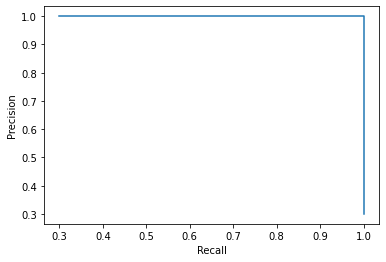

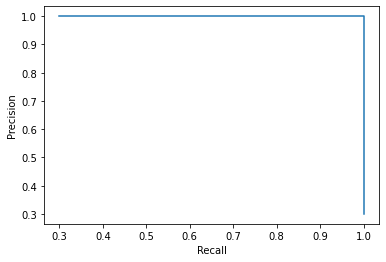

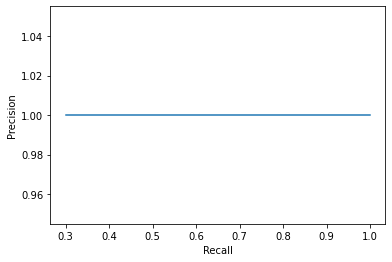

In [53]:
schemaless_curve.plot()
plt.savefig('plots/exp1_1.png')
standard_curve.plot()
plt.savefig('plots/exp1_2.png')
enhanced_curve.plot()
plt.savefig('plots/exp1_3.png')

In [54]:
# schema-less
relevant = list(map(lambda el: el.strip(), open('matrix_qrels.txt').readlines()))

standard_params = {
    'q': 'title:matrix original_title:matrix description:(matrix neo) plot:(matrix neo) ',
    'wt': 'json',
    'defType': 'edismax'
}

schemaless_results = get_results(params=standard_params)

In [55]:
standard_results = get_results(params=standard_params)

enhanced_params = {
    'q': '(original_title:matrix title:matrix) AND (description:neo plot:neo)',
    'wt': 'json',
    'qf': 'original_title description^2 plot^3',
    'defType': 'edismax'
}

enhanced_results = get_results(params=enhanced_params)

In [56]:
print_titles(standard_results)

tt0234215: 2003 The Matrix Reloaded
tt0242653: 2003 The Matrix Revolutions
tt0133093: 1999 The Matrix
tt0970173: 2007 Buhera mátrix
tt0415955: 2004 Maarek hob
tt0292097: 2000 Markova: Comfort Gay
tt0074883: 1976 Maîtresse
tt0102421: 1991 Mayrig
tt0437526: 2007 Une vieille maîtresse
tt0084315: 1982 Les maîtres du temps


In [57]:
print_titles(enhanced_results)

tt0234215: 2003 The Matrix Reloaded
tt0242653: 2003 The Matrix Revolutions
tt0133093: 1999 The Matrix


In [58]:
schemaless_table = metrics_export_table(results=schemaless_results, relevant=relevant)
standard_table = metrics_export_table(results=standard_results, relevant=relevant)
enhanced_table = metrics_export_table(results=enhanced_results, relevant=relevant)

schemaless_curve = curve(results=schemaless_results, relevant=relevant)
standard_curve = curve(results=standard_results, relevant=relevant)
enhanced_curve = curve(results=enhanced_results, relevant=relevant)

In [59]:
print(schemaless_table)
print(standard_table)
print(enhanced_table)

                        0      1
0                  Metric  Value
1       Average Precision    1.0
2  Precision at 10 (P@10)    0.3
                        0      1
0                  Metric  Value
1       Average Precision    1.0
2  Precision at 10 (P@10)    0.3
                        0      1
0                  Metric  Value
1       Average Precision    1.0
2  Precision at 10 (P@10)    0.3


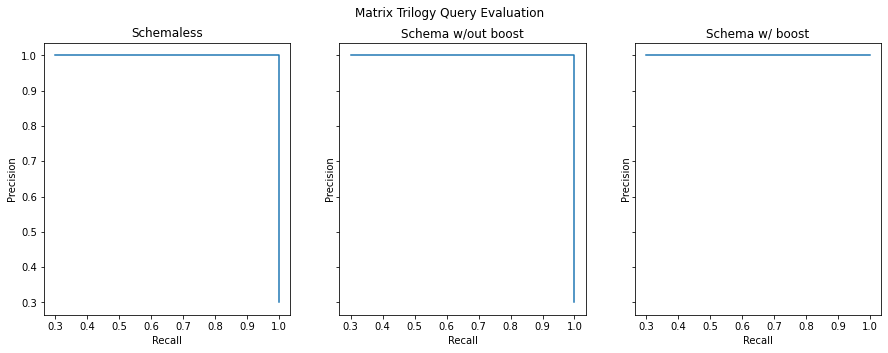

In [60]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(15,5))

ax1.set_title('Schemaless')
ax2.set_title('Schema w/out boost')
ax3.set_title('Schema w/ boost')
fig.suptitle('Matrix Trilogy Query Evaluation')

schemaless_curve.plot(ax=ax1)
standard_curve.plot(ax=ax2)
enhanced_curve.plot(ax=ax3)

plt.show()

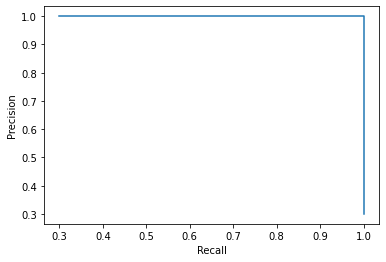

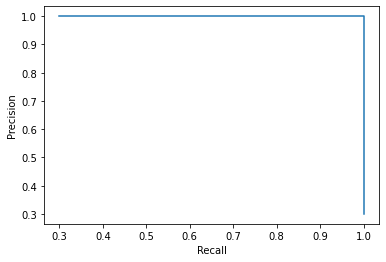

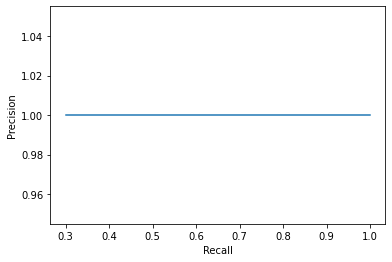

In [61]:
schemaless_curve.plot()
plt.savefig('plots/exp1_1.png')
standard_curve.plot()
plt.savefig('plots/exp1_2.png')
enhanced_curve.plot()
plt.savefig('plots/exp1_3.png')

In [62]:
# schema-less
relevant = list(map(lambda el: el.strip(), open('matrix_qrels.txt').readlines()))

standard_params = {
    'q': 'title:matrix original_title:matrix description:(matrix neo) plot:(matrix neo) ',
    'wt': 'json',
    'defType': 'edismax'
}

schemaless_results = get_results(params=standard_params)

In [63]:
standard_results = get_results(params=standard_params)

enhanced_params = {
    'q': '(original_title:matrix title:matrix) AND (description:neo plot:neo)',
    'wt': 'json',
    'qf': 'original_title description^2 plot^3',
    'defType': 'edismax'
}

enhanced_results = get_results(params=enhanced_params)

In [64]:
print_titles(standard_results)

tt0234215: 2003 The Matrix Reloaded
tt0242653: 2003 The Matrix Revolutions
tt0133093: 1999 The Matrix
tt0970173: 2007 Buhera mátrix
tt0415955: 2004 Maarek hob
tt0292097: 2000 Markova: Comfort Gay
tt0074883: 1976 Maîtresse
tt0102421: 1991 Mayrig
tt0437526: 2007 Une vieille maîtresse
tt0084315: 1982 Les maîtres du temps


In [65]:
print_titles(enhanced_results)

tt0234215: 2003 The Matrix Reloaded
tt0242653: 2003 The Matrix Revolutions
tt0133093: 1999 The Matrix


In [66]:
schemaless_table = metrics_export_table(results=schemaless_results, relevant=relevant)
standard_table = metrics_export_table(results=standard_results, relevant=relevant)
enhanced_table = metrics_export_table(results=enhanced_results, relevant=relevant)

schemaless_curve = curve(results=schemaless_results, relevant=relevant)
standard_curve = curve(results=standard_results, relevant=relevant)
enhanced_curve = curve(results=enhanced_results, relevant=relevant)

In [67]:
print(schemaless_table)
print(standard_table)
print(enhanced_table)

                        0      1
0                  Metric  Value
1       Average Precision    1.0
2  Precision at 10 (P@10)    0.3
                        0      1
0                  Metric  Value
1       Average Precision    1.0
2  Precision at 10 (P@10)    0.3
                        0      1
0                  Metric  Value
1       Average Precision    1.0
2  Precision at 10 (P@10)    0.3


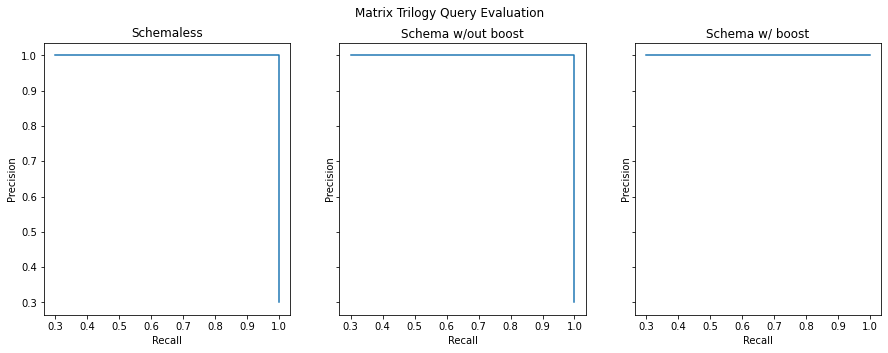

In [68]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(15,5))

ax1.set_title('Schemaless')
ax2.set_title('Schema w/out boost')
ax3.set_title('Schema w/ boost')
fig.suptitle('Matrix Trilogy Query Evaluation')

schemaless_curve.plot(ax=ax1)
standard_curve.plot(ax=ax2)
enhanced_curve.plot(ax=ax3)

plt.show()

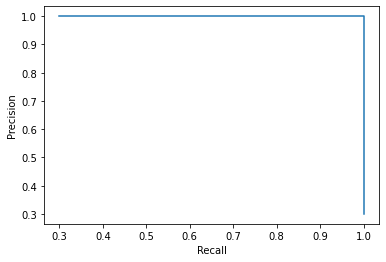

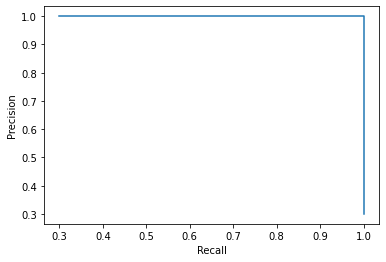

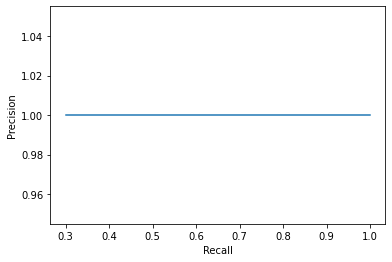

In [69]:
schemaless_curve.plot()
plt.savefig('plots/exp1_1.png')
standard_curve.plot()
plt.savefig('plots/exp1_2.png')
enhanced_curve.plot()
plt.savefig('plots/exp1_3.png')

In [70]:
# schema-less
relevant = list(map(lambda el: el.strip(), open('matrix_qrels.txt').readlines()))

standard_params = {
    'q': 'title:matrix original_title:matrix description:(matrix neo) plot:(matrix neo) ',
    'wt': 'json',
    'defType': 'edismax'
}

schemaless_results = get_results(params=standard_params)

In [71]:
standard_results = get_results(params=standard_params)

enhanced_params = {
    'q': '(original_title:matrix title:matrix) AND (description:neo plot:neo)',
    'wt': 'json',
    'qf': 'original_title description^2 plot^3',
    'defType': 'edismax'
}

enhanced_results = get_results(params=enhanced_params)

In [72]:
print_titles(standard_results)

tt0234215: 2003 The Matrix Reloaded
tt0242653: 2003 The Matrix Revolutions
tt0133093: 1999 The Matrix
tt0970173: 2007 Buhera mátrix
tt0415955: 2004 Maarek hob
tt0292097: 2000 Markova: Comfort Gay
tt0074883: 1976 Maîtresse
tt0102421: 1991 Mayrig
tt0437526: 2007 Une vieille maîtresse
tt0084315: 1982 Les maîtres du temps


In [73]:
print_titles(enhanced_results)

tt0234215: 2003 The Matrix Reloaded
tt0242653: 2003 The Matrix Revolutions
tt0133093: 1999 The Matrix


In [74]:
schemaless_table = metrics_export_table(results=schemaless_results, relevant=relevant)
standard_table = metrics_export_table(results=standard_results, relevant=relevant)
enhanced_table = metrics_export_table(results=enhanced_results, relevant=relevant)

schemaless_curve = curve(results=schemaless_results, relevant=relevant)
standard_curve = curve(results=standard_results, relevant=relevant)
enhanced_curve = curve(results=enhanced_results, relevant=relevant)

In [75]:
print(schemaless_table)
print(standard_table)
print(enhanced_table)

                        0      1
0                  Metric  Value
1       Average Precision    1.0
2  Precision at 10 (P@10)    0.3
                        0      1
0                  Metric  Value
1       Average Precision    1.0
2  Precision at 10 (P@10)    0.3
                        0      1
0                  Metric  Value
1       Average Precision    1.0
2  Precision at 10 (P@10)    0.3


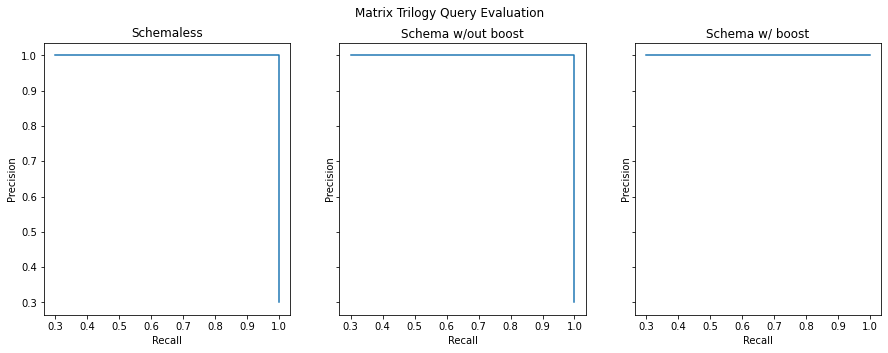

In [76]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(15,5))

ax1.set_title('Schemaless')
ax2.set_title('Schema w/out boost')
ax3.set_title('Schema w/ boost')
fig.suptitle('Matrix Trilogy Query Evaluation')

schemaless_curve.plot(ax=ax1)
standard_curve.plot(ax=ax2)
enhanced_curve.plot(ax=ax3)

plt.show()

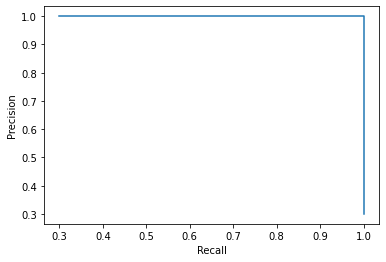

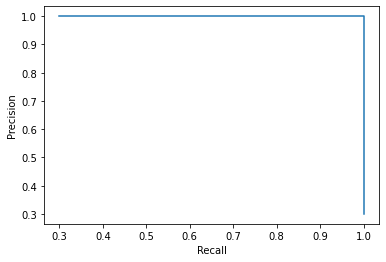

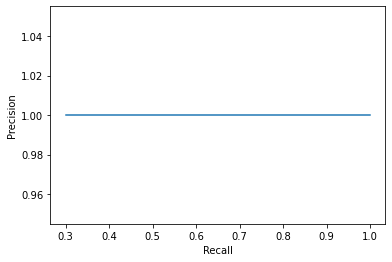

In [39]:
schemaless_curve.plot()
plt.savefig('plots/exp1_1.png')
standard_curve.plot()
plt.savefig('plots/exp1_2.png')
enhanced_curve.plot()
plt.savefig('plots/exp1_3.png')

## Experiment 2 - Harry Potter Franchise

In [77]:
# schema-less
relevant = list(map(lambda el: el.strip(), open('experiment1.txt').readlines()))

standard_params = {
    'q': 'plot:(wizard magic harry) OR description:(wizard magic harry)',
    'wt': 'json',
    'defType': 'edismax',
    'rows': 20,
}

schemaless_results = get_results(params=standard_params)

In [78]:
standard_results = get_results(params=standard_params)

enhanced_params = {
    'q': 'genre:fantasy plot:(wizard magic harry) OR description:(wizard magic harry)',
    'wt': 'json',
    'qf': 'description^2',
    'defType': 'edismax',
    'rows': 20,
}

enhanced_results = get_results(params=enhanced_params)

In [79]:
print_titles(standard_results)

tt0330373: 2005 Harry Potter and the Goblet of Fire
tt0056211: 1962 The Magic Sword
tt0417741: 2009 Harry Potter and the Half-Blood Prince
tt0021287: 1930 Reaching for the Moon
tt0373889: 2007 Harry Potter and the Order of the Phoenix
tt0304141: 2004 Harry Potter and the Prisoner of Azkaban
tt0082288: 1981 Dragonslayer
tt0078504: 1978 The Wiz
tt0092115: 1986 Troll
tt0092723: 1987 The Care Bears Adventure in Wonderland
tt0032138: 1939 The Wizard of Oz
tt0295297: 2002 Harry Potter and the Chamber of Secrets
tt0076929: 1977 Wizards
tt0339334: 2005 The Magic Roundabout
tt0472181: 2011 The Smurfs
tt0091964: 1986 Sky Pirates
tt0098333: 1989 Sinbad of the Seven Seas
tt0033317: 1941 Adventures of Captain Marvel
tt0041162: 1949 Batman and Robin
tt0057546: 1963 The Sword in the Stone


In [80]:
print_titles(enhanced_results)

tt0330373: 2005 Harry Potter and the Goblet of Fire
tt0056211: 1962 The Magic Sword
tt0304141: 2004 Harry Potter and the Prisoner of Azkaban
tt0417741: 2009 Harry Potter and the Half-Blood Prince
tt0021287: 1930 Reaching for the Moon
tt0082288: 1981 Dragonslayer
tt0078504: 1978 The Wiz
tt0092115: 1986 Troll
tt0032138: 1939 The Wizard of Oz
tt0373889: 2007 Harry Potter and the Order of the Phoenix
tt0295297: 2002 Harry Potter and the Chamber of Secrets
tt0076929: 1977 Wizards
tt0092723: 1987 The Care Bears Adventure in Wonderland
tt0339334: 2005 The Magic Roundabout
tt0472181: 2011 The Smurfs
tt0033317: 1941 Adventures of Captain Marvel
tt0104855: 1993 Merlin
tt0097174: 1988 Deathstalker and the Warriors from Hell
tt0165866: 1998 Lucinda's Spell
tt0091964: 1986 Sky Pirates


In [81]:
schemaless_table = metrics_export_table(results=schemaless_results, relevant=relevant)
standard_table = metrics_export_table(results=standard_results, relevant=relevant)
enhanced_table = metrics_export_table(results=enhanced_results, relevant=relevant)

schemaless_curve = curve(results=schemaless_results, relevant=relevant)
standard_curve = curve(results=standard_results, relevant=relevant)
enhanced_curve = curve(results=enhanced_results, relevant=relevant)

In [82]:
print(schemaless_table)
print(standard_table)
print(enhanced_table)

                        0       1
0                  Metric   Value
1       Average Precision  0.5875
2  Precision at 10 (P@10)     0.4
                        0       1
0                  Metric   Value
1       Average Precision  0.5875
2  Precision at 10 (P@10)     0.4
                        0         1
0                  Metric     Value
1       Average Precision  0.567803
2  Precision at 10 (P@10)       0.4


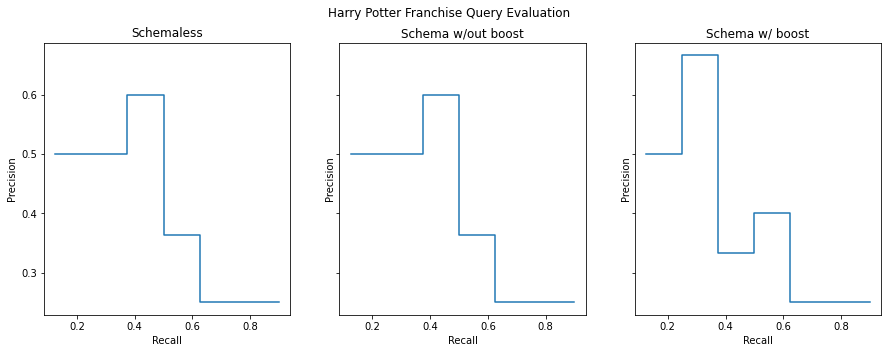

In [83]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(15,5))

ax1.set_title('Schemaless')
ax2.set_title('Schema w/out boost')
ax3.set_title('Schema w/ boost')
fig.suptitle('Harry Potter Franchise Query Evaluation')

schemaless_curve.plot(ax=ax1)
standard_curve.plot(ax=ax2)
enhanced_curve.plot(ax=ax3)

plt.show()

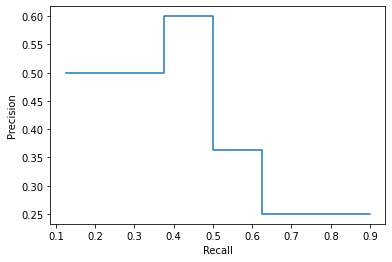

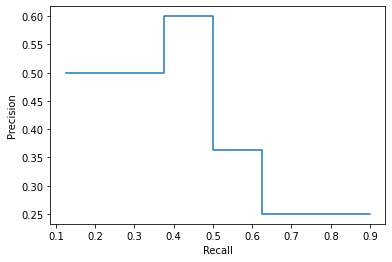

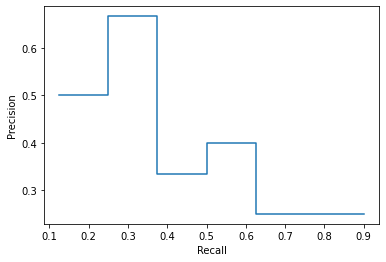

In [84]:
schemaless_curve.plot()
plt.savefig('plots/exp2_1.png')
standard_curve.plot()
plt.savefig('plots/exp2_2.png')
enhanced_curve.plot()
plt.savefig('plots/exp2_3.png')

## Experiment 3 - Toy Story Franchise

In [85]:
# schema-less
relevant = list(map(lambda el: el.strip(), open('experiment2.txt').readlines()))

standard_params = {
    'q': 'plot:(toy woody) description:(toy woody)',
    'wt': 'json',
    'defType': 'edismax',
}

schemaless_results = get_results(params=standard_params)

In [86]:
standard_results = get_results(params=standard_params)

enhanced_params = {
    'q': 'genre:animation original_title:toy plot:(toy woody) description:(toy woody)',
    'wt': 'json',
    'qf': 'description^3 original_title^2 genre',
    'defType': 'edismax',
}

enhanced_results = get_results(params=enhanced_params)

In [87]:
print_titles(standard_results)

tt0120363: 1999 Toy Story 2
tt0435761: 2010 Toy Story 3
tt0114709: 1995 Toy Story
tt0082199: 1981 Condorman
tt1460643: 2010 Pimp
tt1218345: 2008 Dil Kabaddi
tt0122718: 1998 Small Soldiers
tt1979376: 2019 Toy Story 4
tt0105629: 1992 Toys
tt0076416: 1977 The Mouse and His Child


In [88]:
print_titles(enhanced_results)

tt0120363: 1999 Toy Story 2
tt0435761: 2010 Toy Story 3
tt0114709: 1995 Toy Story
tt1979376: 2019 Toy Story 4
tt0076416: 1977 The Mouse and His Child
tt0082199: 1981 Condorman
tt1460643: 2010 Pimp
tt1218345: 2008 Dil Kabaddi
tt0100281: 1990 The Nutcracker Prince
tt0105629: 1992 Toys


In [89]:
schemaless_table = metrics_export_table(results=schemaless_results, relevant=relevant)
standard_table = metrics_export_table(results=standard_results, relevant=relevant)
enhanced_table = metrics_export_table(results=enhanced_results, relevant=relevant)

schemaless_curve = curve(results=schemaless_results, relevant=relevant)
standard_curve = curve(results=standard_results, relevant=relevant)
enhanced_curve = curve(results=enhanced_results, relevant=relevant)

In [90]:
print(schemaless_table)
print(standard_table)
print(enhanced_table)

                        0         1
0                  Metric     Value
1       Average Precision  0.833333
2  Precision at 10 (P@10)       0.4
                        0         1
0                  Metric     Value
1       Average Precision  0.833333
2  Precision at 10 (P@10)       0.4
                        0      1
0                  Metric  Value
1       Average Precision    1.0
2  Precision at 10 (P@10)    0.4


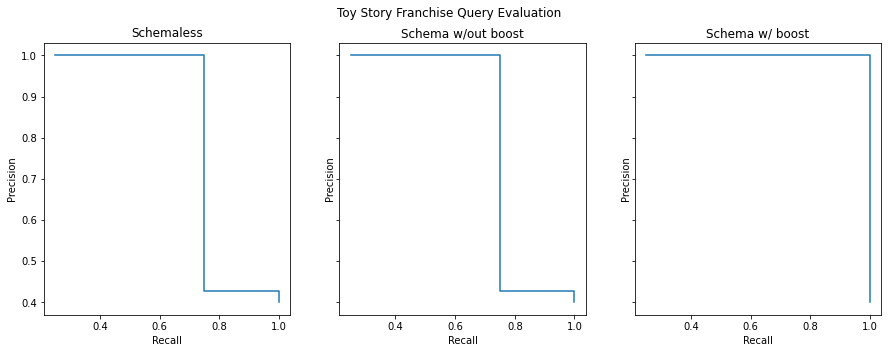

In [91]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(15,5))

ax1.set_title('Schemaless')
ax2.set_title('Schema w/out boost')
ax3.set_title('Schema w/ boost')
fig.suptitle('Toy Story Franchise Query Evaluation')

schemaless_curve.plot(ax=ax1)
standard_curve.plot(ax=ax2)
enhanced_curve.plot(ax=ax3)

plt.show()

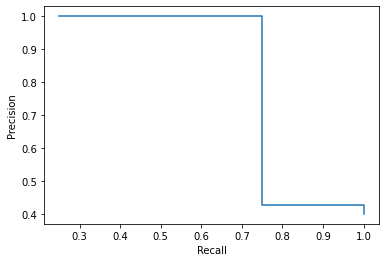

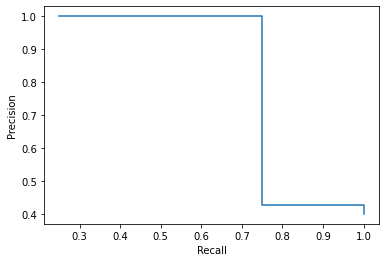

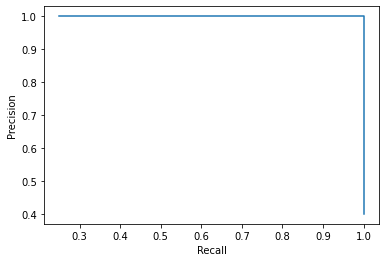

In [92]:
schemaless_curve.plot()
plt.savefig('plots/exp2_1.png')
standard_curve.plot()
plt.savefig('plots/exp2_2.png')
enhanced_curve.plot()
plt.savefig('plots/exp2_3.png')